In [15]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import random
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import os,sys
opj = os.path.join
from tqdm import tqdm
from random import randint
from copy import deepcopy
import pickle as pkl
import argparse

from torch import nn
from models import AutoEncoder, AutoEncoderSimple, load_model
import torch.nn.functional as F

from models import load_model
sys.path.append('../../src')
sys.path.append('../../src/vae')
sys.path.append('../../src/vae/models')
sys.path.append('../../src/dsets/cosmology')
from dset import get_dataloader
from model import init_specific_model
from losses import get_loss_f, _reconstruction_loss
from training import Trainer
from viz import viz_im_r, cshow, viz_filters
from sim_cosmology import p

sys.path.append('../../lib/trim')
# trim modules
from trim import DecoderEncoder, TrimModel
from captum.attr import *

# wavelet
from pytorch_wavelets import DTCWTForward, DTCWTInverse

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## VAE on cosmology data

In [50]:
class AutoEncoderSimple(nn.Module):
    def __init__(self, img_size=(1,256,256), hid_channels=2):
        """
        Class which defines model and forward pass. Consists of one layer of Conv and ConvTranspose.
        Parameters
        ----------
        img_size : tuple of (C,H,W)
        
        hid_channels : int
            number of hidden channels
        """
        super(AutoEncoderSimple, self).__init__()
        
        # Layer parameters
        kernel_size = 4
        n_chan = img_size[0]
        self.img_size = img_size

        # Convolutional layers
        cnn_kwargs = dict(stride=2, padding=1)
        self.conv1 = nn.Conv2d(n_chan, hid_channels, kernel_size, **cnn_kwargs)       

        # Transpose Convolutional layers
        self.convT1 = nn.ConvTranspose2d(hid_channels, n_chan, kernel_size, **cnn_kwargs)
        
    def encoder(self, x):
        batch_size = x.size(0)

        # Convolutional layers with ReLu activations
        x = self.conv1(x)
        x = torch.relu(x)
        
        return x
    
    def decoder(self, x):
        batch_size = x.size(0)
        
        x = self.convT1(x)
        x = torch.tanh(x)

        return x            

    def forward(self, x):
        """
        Forward pass of model.
        Parameters
        ----------
        x : torch.Tensor
            Batch of data. Shape (batch_size, n_chan, height, width)
        """
        latent_sample = self.encoder(x)
        reconstruct = self.decoder(latent_sample)
        
        return reconstruct, latent_sample  
    

In [52]:
# create dir
out_dir = opj(p.out_dir, p.dirname)
os.makedirs(out_dir, exist_ok=True)  

# seed
random.seed(p.seed)
np.random.seed(p.seed)
torch.manual_seed(p.seed)

# get dataloaders
train_loader = get_dataloader(p.data_path, 
                              img_size=64,
                              batch_size=p.train_batch_size)
im = iter(train_loader).next()[0].to(device)

# prepare model
model = AutoEncoderSimple(img_size=im.shape[1:], hid_channels=2).to(device)

# train
optimizer = torch.optim.Adam(model.parameters(), lr=p.lr)

In [17]:
# Training Loop
# Lists to keep track of progress
losses = []
num_epochs = 50

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    epoch_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader, 0):
        data = data.to(device)
        recon_data, latent_sample = model(data)
        # loss
        loss = _reconstruction_loss(data, recon_data, distribution="gaussian", storer=None)
        # zero grad
        optimizer.zero_grad()
        # backward
        loss.backward()
        # Update step
        optimizer.step()
        
        epoch_loss += loss.data.item()

        # Output training stats
        if batch_idx % 50 == 0:
            print('\rTrain Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                       100. * batch_idx / len(train_loader), loss.data.item()), end='')
        

    # Save Losses for plotting later
    losses.append(epoch_loss/(batch_idx + 1))

# SAVE MODEL
# torch.save(model.state_dict(), 'results/autoenc_2layer.pth')

Starting Training Loop...
Train Epoch: 49 [28800/30000 (96%)]	Loss: 0.033728

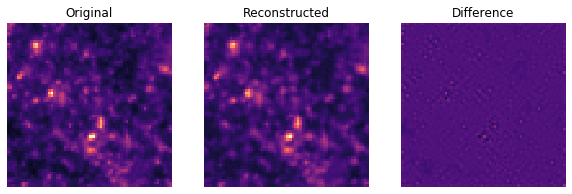

In [44]:
im = iter(train_loader).next()[0].to(device)
recon_data, latent_sample = model(im)
viz_im_r(im[0,0], recon_data[0,0])

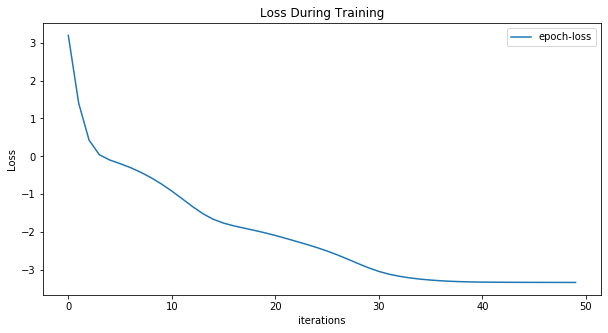

In [19]:
# loss versus training iterations
plt.figure(figsize=(10,5))
plt.title("Loss During Training")
plt.plot(np.log(losses), label="epoch-loss")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

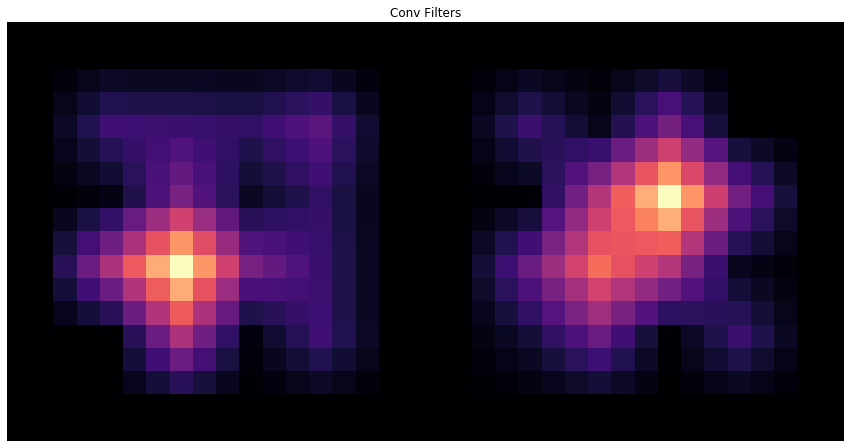

In [27]:
viz_filters(model.conv1.weight[:,0,...], n_row=1, n_col=2, resize_fac=3, normalize=True, title='Conv Filters')

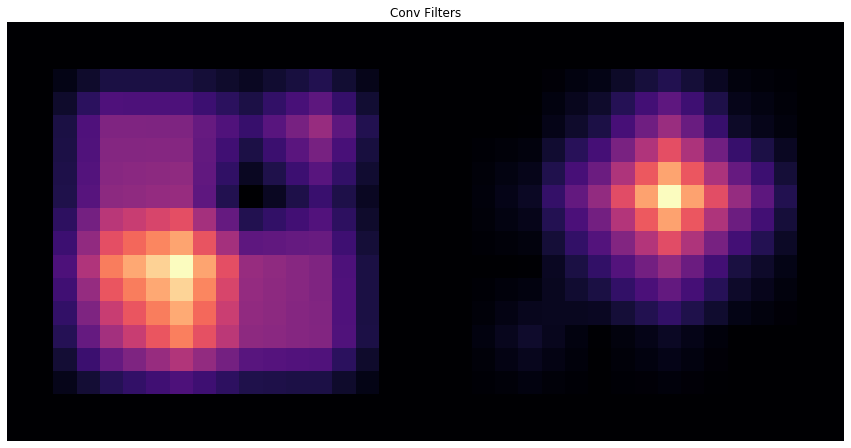

In [28]:
viz_filters(model.convT1.weight[:,0,...], n_row=1, n_col=2, resize_fac=3, normalize=True, title='Conv Filters')

In [ ]:
model.encoder(im)[0].shape

In [ ]:
viz_filters(model.encoder(im)[0], n_row=1, n_col=3, normalize=True, resize_fac=1, title='Representation')